In [563]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
import seaborn as sns

In [350]:
df_raw = pd.read_pickle('USGS_raw_data.pickle')
df = df_raw.dropna(axis=1, thresh=365*5)
stations = pd.read_pickle('USGS_stations.pickle')

In [672]:
def plotfit(X,y,lr):
    
    plt.subplots(figsize=(10,10))
    
    ax = plt.subplot(2,1,1)
    plt.plot(y,'k.',alpha=0.8)
    plt.plot(pd.Series(lr.predict(X),index=y.index),'c.',alpha=0.8)
    ax.set_xlabel('year',fontsize=12)
    ax.set_ylabel('log(turbidity)',fontsize=12)
    ax.legend(['measured','predicted'],fontsize=12)
    ax.set_title('Time Series Plot',fontweight='bold')
    
    ax = plt.subplot(2,2,3)
    plt.scatter(lr.predict(X),y,alpha=0.3,color='black')
    plt.plot([3,5],[3,5],'w--',alpha=0.7,linewidth=3)
    ax.set_xlabel('measured turbidity (log)',fontsize=12)
    ax.set_ylabel('predicted turbidity (log)',fontsize=12)
    ax.set_title('Measured vs. Predicted',fontweight='bold')

    ax = plt.subplot(2,2,4)
    ax.set_title('Residual Histogram',fontweight='bold')
    ax.set_xlabel('residual',fontsize=12)
    ax.set_ylabel('count',fontsize=12)
    plt.hist(lr.predict(X)-y,bins=20,color='#999999');

### Basic fit with all 119 stations

In [596]:
# apply log transformation to all variables
lr = LinearRegression()
data = df.dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
lr.fit(X,y)
print(len(X.columns))
print(lr.score(X,y))
#plotfit(X,y,lr)

113
0.795497681407


In [648]:
# apply LassoCV to all stations

scores = []
nums = []

alphas = np.logspace(-10,0,num=100)
for alpha in alphas:
    lcv = LassoCV(cv=6, alphas=[alpha])
    data = df.dropna().apply(np.log)
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna(axis=1)
    # Note: important here to shuffle
    data = data.sample(frac=1)
    X = data.drop(['turbidity'],axis=1)
    y = data['turbidity']
    lcv.fit(X,y)
    scores.append(lcv.score(X,y))
    abscoef = abs(lcv.coef_)
    # plt.bar(x=range(len(abscoef[abscoef>1e-10])),height = sorted(abscoef[abscoef>1e-10]))
    nums.append(len(abscoef[abscoef>1e-10]))

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

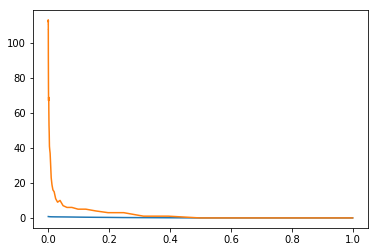

In [650]:
plt.plot(alphas,scores)
plt.plot(alphas,nums)

-0.648164941112


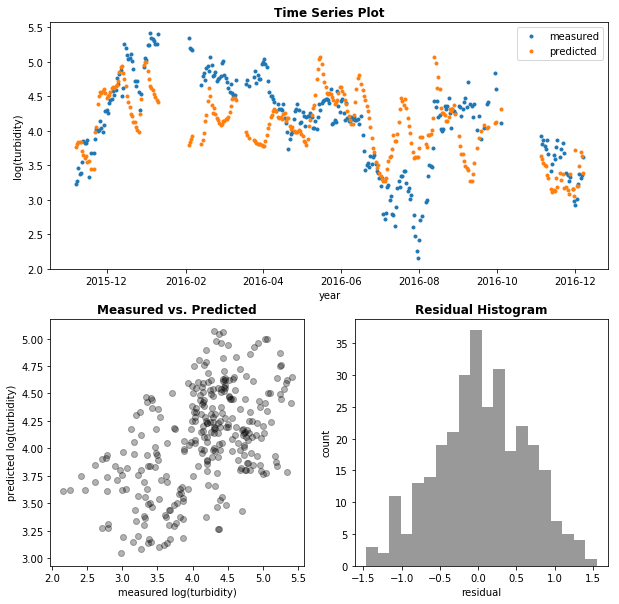

In [643]:
# apply log transformation to all variables
lr = LinearRegression()
data = df[selected].dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)

# data = data.sample(frac=1)

X = data.drop(['turbidity'],axis=1)
y = data['turbidity']

n = 1200
X_train = X.iloc[:n,:]
y_train = y[:n]
X_test = X.iloc[n:,]
y_test = y[n:]

lr.fit(X_train,y_train)
# lr.fit(X,y)
print(lr.score(X_test,y_test))
y_pred = lr.predict(X_test)
plotfit(X_test,y_test,lr)

In [642]:
sumE = 0
for i in range(len(y_pred)):
    sumE += (y_pred[i]-y_test[i])**2
sumE = sumE/len(y_pred)
print(1-sumE/y_test.var())

-0.549055011244


0.456912115914


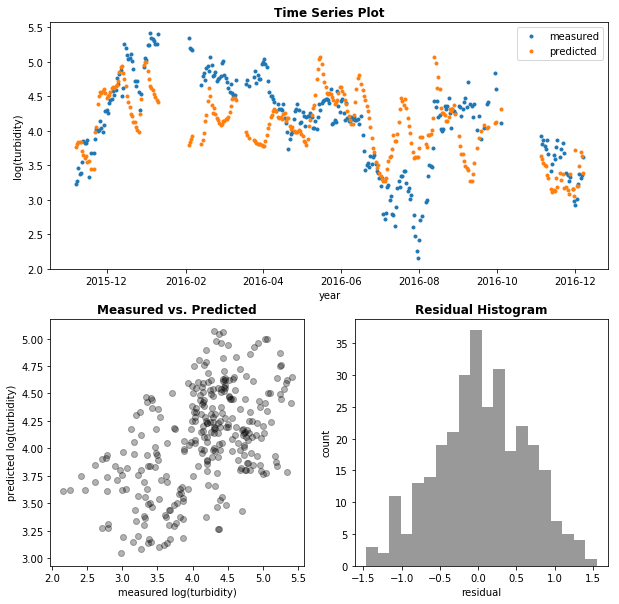

In [646]:
# apply LassoCV to all stations

alphas = np.logspace(-10,0,num=100)
data = df.dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
# Note: important here to shuffle
data = data.sample(frac=1)
X = data.drop(['turbidity'],axis=1)
y = data['turbidity']

lcv = LassoCV(cv=6, alphas=alphas)
lcv.fit(X_train,y_train)

print(lcv.score(X_test,y_test))
y_pred = lcv.predict(X_test)
plotfit(X_test,y_test,lr)

### Using recursive feature elimination

0.673390714965


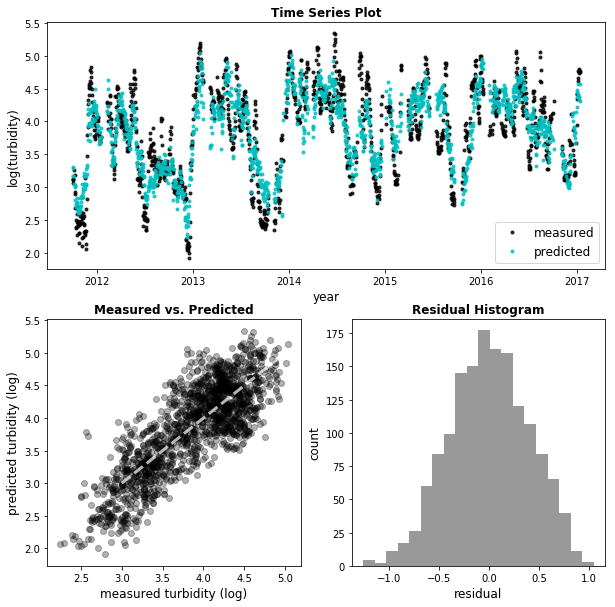

In [673]:
# Recursive Feature Elimination

from sklearn.feature_selection import RFE

lr = LinearRegression()
data = df.dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
# data = df.dropna().apply(np.log)
# data = data.replace([np.inf, -np.inf], np.nan)
# data = data.dropna(axis=1)

X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
# create the RFE model and select 10 attributes
rfe = RFE(lr, 20)
rfe = rfe.fit(X, y)
# # summarize the selection of the attributes
# print(rfe.support_)
# print(rfe.ranking_)

cols = X.columns[rfe.support_]
group = list(cols)
group.append('turbidity')
# sns.pairplot(df[[<insert the columns of your df here>]])
# sns.heatmap(df[group].corr())     #<---- will give you a good visualization of the correlation matrix

# lr = LinearRegression()
# data = df[group].dropna().apply(np.log)
# data = data.replace([np.inf, -np.inf], np.nan)
# data = data.dropna(axis=1)
# X = data.drop(['turbidity'],axis=1)
# y = data['turbidity']
# rfe = RFE(lr, 15)
# rfe = rfe.fit(X, y)
# cols = X.columns[rfe.support_]
# group = list(cols)
# group.append('turbidity')

lr = LinearRegression()
data = df[group].dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
lr.fit(X,y)
print(lr.score(X,y))
plotfit(X,y,lr)

In [669]:
print('total # of stations: %d'%len(X.columns))
stations.loc[X.columns,'site_name']

total # of stations: 20


03110690      OHIO R AT NEW CUMBERLAND LOCK & DAM (LOWER), OH
03111520         OHIO R AT PIKE ISLAND LOCK & DAM (LOWER), WV
03430250    CUMBERLAND RIVER AT STONES RIVER NEAR HERMITAG...
03430320     CUMBERLAND RIVER AT BRILEY PKWY NR INGLEWOOD, TN
03431712     CUMBERLAND RIVER AT BRILEY PKWY AT COCKRILL BEND
03594500                  TENNESSEE RIVER AT PERRYVILLE, TENN
05587060                         ILLINOIS RIVER AT HARDIN, IL
06090300                   Missouri River near Great Falls MT
06090800                     Missouri River at Fort Benton MT
06341000                       MISSOURI RIVER AT WASHBURN, ND
06342020                          MISSOURI RIVER AT PRICE, ND
06342500                       MISSOURI RIVER AT BISMARCK, ND
06441595              MISSOURI R AT FARM ISLAND NR PIERRE, SD
06610000                          Missouri River at Omaha, NE
06807000                  Missouri River at Nebraska City, NE
06813500                           Missouri River at Rulo, NE
06818000

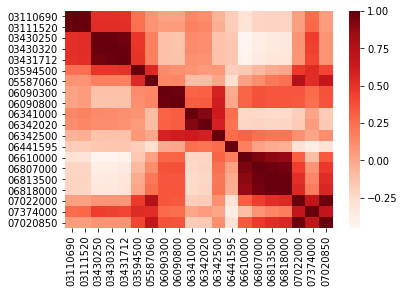

In [670]:
sns.heatmap(X.corr(),cmap='Reds')

In [655]:
# find groups of colinear features
d = {}
c = X.corr()
st_list = list(c.columns)
corr_thresh = 0.9

while len(st_list)>0:
    st_key = st_list[0]
    d[st_key] = []
    for st in st_list:
        if c.loc[st,st_key] > corr_thresh:
            d[st_key].append(st)
    for st in d[st_key]:
        st_list.remove(st)
        
# test each station in each group with multiple stations
d_select = dict.fromkeys(d.keys())

for key in d.keys():
    if len(d[key])>1: # multiple stations
        r2 = 0
        for st in d[key]:
            to_remove = list(d[key])
            to_remove.remove(st)
            lr = LinearRegression()
            Xnew = X.drop(to_remove,axis=1)
            lr.fit(Xnew,y)
            if lr.score(Xnew,y)>r2:
                r2 = lr.score(Xnew,y)
                d_select[key] = (st,r2)
d_select

{'03110690': ('03111520', 0.65222450123399622),
 '03430250': ('03431712', 0.64477699001019118),
 '03594500': None,
 '06090300': ('06090300', 0.61420499640151638),
 '06342020': None,
 '06441595': None,
 '06813500': ('06818000', 0.63938045763111573),
 '07022000': ('07022000', 0.63877663271495233),
 '07374000': None}

In [656]:
selected = []
for key in d_select.keys():
    if d_select[key] is None:
        selected.append(key)
    else:
        selected.append(d_select[key][0])

print(selected)

['03111520', '03431712', '03594500', '06090300', '06342020', '06441595', '06818000', '07022000', '07374000']


In [702]:
lr = LinearRegression()
selected.append('turbidity')
data = df[selected].dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
lr.fit(X,y)
lr.score(X,y)
# plotfit(X,y,lr)

0.57476872092323128

In [703]:
print('total # of stations: %d'%len(X.columns))
stations.loc[X.columns,'site_name']

total # of stations: 9


03111520        OHIO R AT PIKE ISLAND LOCK & DAM (LOWER), WV
03431712    CUMBERLAND RIVER AT BRILEY PKWY AT COCKRILL BEND
03594500                 TENNESSEE RIVER AT PERRYVILLE, TENN
06090300                  Missouri River near Great Falls MT
06342020                         MISSOURI RIVER AT PRICE, ND
06441595             MISSOURI R AT FARM ISLAND NR PIERRE, SD
06818000                    Missouri River at St. Joseph, MO
07022000                     Mississippi River at Thebes, IL
07374000                Mississippi River at Baton Rouge, LA
Name: site_name, dtype: object

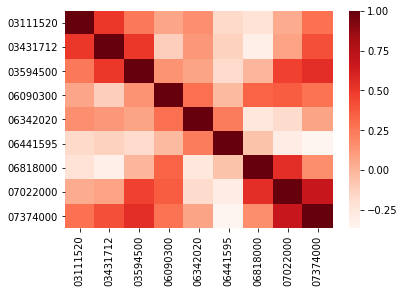

In [659]:
sns.heatmap(X.corr(),cmap='Reds')

In [660]:
Xsm = sm.add_constant(X)
# Create your model and
# Fit your model to your training set
smfit = sm.OLS(y,Xsm).fit()
smfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              turbidity   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     239.1
Date:                Thu, 01 Feb 2018   Prob (F-statistic):          4.34e-288
Time:                        20:12:10   Log-Likelihood:                -1006.2
No. Observations:                1602   AIC:                             2032.
Df Residuals:                    1592   BIC:                             2086.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.4254      2.303    -12.341      0.000     -32.943     -23.907
03111520      -0.1429      0.081     -1.755      0.080      -0.303       0.017
03431712       0.1339      0.139      0.961      0.337      -0.139       0.407
03594500       1.9915      0.378      5.273      0.000       1.251       2.732
06090300       0.0253      0.047      0.543      0.587      -0.066       0.117
06342020       1.4596      0.179      8.135      0.000       1.108       1.812
06441595       3.0007      0.622      4.822      0.000       1.780       4.221
06818000      -0.1248      0.043     -2.885      0.004      -0.210      -0.040
07022000       0.1063      0.036      2.986      0.003       0.036       0.176
07374000       0.8141      0.036     22.746      0.000       0.744       0.884
==============================================================================
Omnibus:                        6.724   Durbin-Watson:                   0.109
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.788
Skew:                          -0.149   Prob(JB):                       0.0336
Kurtosis:                       2.887   Cond. No.                     4.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [693]:
# apply ElasticNet CV on selected features
from sklearn.linear_model import ElasticNetCV

alphas = np.logspace(-2.5,3,num=20)
ecv = ElasticNetCV(cv=6, alphas=alphas,l1_ratio=1)
data = df[group].dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
# Note: important here to shuffle
data = data.sample(frac=1)
X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
ecv.fit(X,y)
ecv.score(X,y)


0.57942822995664656

In [694]:
newlist = list(zip(ecv.coef_,stations.loc[X.columns,'site_name']))
for item in newlist:
    print(item)

(-0.0, 'OHIO R AT NEW CUMBERLAND LOCK & DAM (LOWER), OH')
(-0.0, 'OHIO R AT PIKE ISLAND LOCK & DAM (LOWER), WV')
(0.016090553782265433, 'CUMBERLAND RIVER AT STONES RIVER NEAR HERMITAGE,TN')
(0.0, 'CUMBERLAND RIVER AT BRILEY PKWY NR INGLEWOOD, TN')
(0.0, 'CUMBERLAND RIVER AT BRILEY PKWY AT COCKRILL BEND')
(0.0, 'TENNESSEE RIVER AT PERRYVILLE, TENN')
(-0.0, 'ILLINOIS RIVER AT HARDIN, IL')
(0.79584723745823649, 'Missouri River near Great Falls MT')
(-0.75144176267797225, 'Missouri River at Fort Benton MT')
(1.0408355588664757, 'MISSOURI RIVER AT WASHBURN, ND')
(0.0, 'MISSOURI RIVER AT PRICE, ND')
(-0.12269366336294467, 'MISSOURI RIVER AT BISMARCK, ND')
(0.0, 'MISSOURI R AT FARM ISLAND NR PIERRE, SD')
(0.0, 'Missouri River at Omaha, NE')
(0.0, 'Missouri River at Nebraska City, NE')
(0.0, 'Missouri River at Rulo, NE')
(-0.057909209322868416, 'Missouri River at St. Joseph, MO')
(0.31484123509718293, 'Mississippi River at Thebes, IL')
(0.82880340364224037, 'Mississippi River at Baton Rouge, L

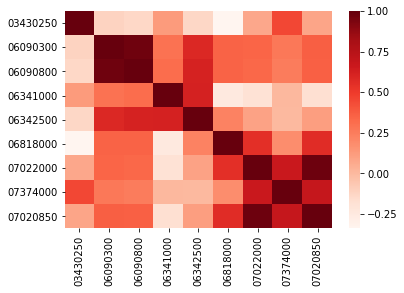

In [701]:
sns.heatmap(X[X.columns[abs(ecv.coef_)>1e-10]].corr(),cmap='Reds')

In [696]:
newlist = list(zip(ecv.coef_,stations.loc[X.columns,'site_name']))
for item in newlist:
    print(item)

(-0.0, 'OHIO R AT NEW CUMBERLAND LOCK & DAM (LOWER), OH')
(-0.0, 'OHIO R AT PIKE ISLAND LOCK & DAM (LOWER), WV')
(0.016090553782265433, 'CUMBERLAND RIVER AT STONES RIVER NEAR HERMITAGE,TN')
(0.0, 'CUMBERLAND RIVER AT BRILEY PKWY NR INGLEWOOD, TN')
(0.0, 'CUMBERLAND RIVER AT BRILEY PKWY AT COCKRILL BEND')
(0.0, 'TENNESSEE RIVER AT PERRYVILLE, TENN')
(-0.0, 'ILLINOIS RIVER AT HARDIN, IL')
(0.79584723745823649, 'Missouri River near Great Falls MT')
(-0.75144176267797225, 'Missouri River at Fort Benton MT')
(1.0408355588664757, 'MISSOURI RIVER AT WASHBURN, ND')
(0.0, 'MISSOURI RIVER AT PRICE, ND')
(-0.12269366336294467, 'MISSOURI RIVER AT BISMARCK, ND')
(0.0, 'MISSOURI R AT FARM ISLAND NR PIERRE, SD')
(0.0, 'Missouri River at Omaha, NE')
(0.0, 'Missouri River at Nebraska City, NE')
(0.0, 'Missouri River at Rulo, NE')
(-0.057909209322868416, 'Missouri River at St. Joseph, MO')
(0.31484123509718293, 'Mississippi River at Thebes, IL')
(0.82880340364224037, 'Mississippi River at Baton Rouge, L

#### <font color='red'> keep the print out below for reference

In [438]:
stations.loc(list(X.columns))

In [442]:
newlist = list(zip(ecv.coef_,stations.loc[X.columns,'site_name']))
for item in newlist:
    print(item)

(-0.14257528699673039, 'OHIO R AT PIKE ISLAND LOCK & DAM (LOWER), WV')
(0.13393877080723182, 'CUMBERLAND RIVER AT BRILEY PKWY AT COCKRILL BEND')
(1.9852575152751604, 'TENNESSEE RIVER AT PERRYVILLE, TENN')
(0.025281000245090973, 'Missouri River near Great Falls MT')
(1.4599583510601462, 'MISSOURI RIVER AT PRICE, ND')
(2.9796264283735585, 'MISSOURI R AT FARM ISLAND NR PIERRE, SD')
(-0.12469916236807262, 'Missouri River at St. Joseph, MO')
(0.10631151310145809, 'Mississippi River at Thebes, IL')
(0.81395289647496316, 'Mississippi River at Baton Rouge, LA')


In [390]:
# # load test data
# df_test = pd.read_pickle('USGS_test_data.pickle')

# lr = LinearRegression()
# data = df_test[selected].dropna().apply(np.log)
# data = data.replace([np.inf, -np.inf], np.nan)
# data = data.dropna(axis=1)
# X = data.drop(['turbidity'],axis=1)
# y = data['turbidity']
# lr.fit(X,y)
# lr.score(X,y)
# plotfit(X,y,lr)
